In [19]:
import matplotlib.pyplot as plt
import random
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
from scipy.stats import chisquare
import warnings
import pandas as pd

STATPATH ='/home/bule/projects/Dice/rasperry_run/static'# r'C:\Users\buehl\repos\Dice\workspace\data\dicesides'

# Function to place an image on the plot
def place_image(ax, img_path, xy, zoom=1):
    # Load the image
    img = plt.imread(img_path)
    
    # Create an OffsetImage
    imagebox = OffsetImage(img, zoom=zoom)
    
    # Create an AnnotationBbox
    ab = AnnotationBbox(imagebox, xy, frameon=True, xybox=(10, -15), boxcoords="offset points", pad=0)
    
    # Add it to the axes
    ax.add_artist(ab)

def histplot(rolls,dicecolor='red'):

    # Theoretical distribution for a fair dice (uniform distribution)
    fair_probs = [1/6] * 6  # Since each outcome (1-6) has an equal probability
    # Simulating rolls for an unfair dice
    outcomes = [1, 2, 3, 4, 5, 6]
    weights = [10, 10, 10, 10, 10, 30]  # Example weights: 5 and 6 are three times more likely

    # replace line with the IO from results
    #rolls = random.choices(outcomes, weights, k=20)

    # Counting the frequency of each outcome for the unfair dice
    
    unfair_probs = [rolls.count(i) / len(rolls) for i in range(1, 7)]
    observed_frequencies = [rolls.count(i) for i in range(1, 7)]
    expected_frequencies = [len(rolls) / 6] * 6
    chi_squared_stat, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)


    # Create the plot
    fig, ax = plt.subplots()

    # Plotting the bar charts
    ax.bar(range(1, 7), fair_probs, alpha=1, color='#0165A8', label='Theoretisch', width=0.4)
    
    if dicecolor == 'red':
        ax.bar([x + 0.4 for x in range(1, 7)], unfair_probs, alpha=0.8, color='red', label='Gewürfelt', width=0.4)
    elif dicecolor == 'white':
        ax.bar([x + 0.4 for x in range(1, 7)], unfair_probs, alpha=0.8, edgecolor='black', color='white', label='Gewürfelt', width=0.4)

    # Remove numerical x-tick labels and place images instead
    ax.set_xticks(range(1, 7))
    ax.set_xticklabels([])  # Remove x-tick labels
    ax.tick_params(axis='both', which='both', length=0)  # Remove axis ticks

    for i in range(1, 7):
        place_image(ax, os.path.join(STATPATH, f'side{i}.jpg'), xy=(i, 0), zoom=0.04)
        
    plt.title(f'Häufigkeiten von Würfelergebnissen, Anzahl Würfe: {len(rolls)} p= {p_value:.3f}')
    plt.legend()
    plt.xlabel('Würfel Augen', labelpad=30)
    plt.ylabel('Relative Häufigkeit')

    # Show the plot
    plt.show()

#rolls = random.choices(outcomes, weights, k=20)
#histplot(rolls,dicecolor='white')

In [ ]:
def plot_histogram(data_path, column_name):
    
    # TODO error thrown when flaots in csv -> handle
    with matplotlib_lock:
        df = pd.read_csv(data_path)
    
        rolls=df[column_name].dropna().tolist()
        # Theoretical distribution for a fair dice (uniform distribution)
        fair_probs = [1/6] * 6  # Since each outcome (1-6) has an equal probability
        
        p_value=0
        if len(rolls) != 0:
            # Counting the frequency of each outcome for the unfair dice
            unfair_probs = [rolls.count(i) / len(rolls) for i in range(1, 7)]
            observed_frequencies = [rolls.count(i) for i in range(1, 7)]
            expected_frequencies = [len(rolls) / 6] * 6
            chi_squared_stat, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)
        
        # Create the plot
        fig, ax = plt.subplots()

        # Plotting the bar charts
        ax.bar(range(1, 7), fair_probs, alpha=1, color='#0165A8', label='Theoretisch', width=0.4)
        
        if len(rolls) != 0 and column_name == 'red':
            ax.bar([x + 0.4 for x in range(1, 7)], unfair_probs, alpha=0.8, color='red', label='Gewürfelt', width=0.4)
        elif len(rolls) != 0 and column_name == 'white':
            ax.bar([x + 0.4 for x in range(1, 7)], unfair_probs, alpha=0.8, edgecolor='black', color='white', label='Gewürfelt', width=0.4)

        # Remove numerical x-tick labels and place images instead
        ax.set_xticks(range(1, 7))
        ax.set_xticklabels([])  # Remove x-tick labels
        ax.tick_params(axis='both', which='both', length=0)  # Remove axis ticks

        for i in range(1, 7):
            place_image(ax, os.path.join(STATPATH, f'side{i}.jpg'), xy=(i, 0), zoom=0.04)
            
        plt.title(f'Häufigkeiten von Würfelergebnissen, Anzahl Würfe: {len(rolls)} p= {p_value:.3f}')
        plt.legend()
        plt.xlabel('Würfel Augen', labelpad=30)
        plt.ylabel('Relative Häufigkeit')
                

        img = BytesIO()
        plt.savefig(img, format='png')
        img.seek(0)
        plt.close()
        return img

## Recoridng mechanism for frameloop

In [9]:

def append_to_csv(filepath, new_df):
    existing_df = pd.read_csv(filepath)
    updated_df = pd.concat([existing_df, new_df], ignore_index=True)
    updated_df.to_csv(filepath, index=False)

def check_empty_dice_results(filepath):
    df = pd.read_csv(filepath)
    if df.empty:
        return True
    return False

def create_dataframe_fillNA(data:dict):
    ''' Create a DataFrame from a dictionary and fill missing values with NaN'''
    max_length = max(len(values) for values in data.values())
    for key, values in data.items():
        data[key] = values + [None] * (max_length - len(values))
    return pd.DataFrame(data)

def dummy_dice_pred():
    dice_dict = {"white": [], "red": []}
    
    for color in dice_dict:
        num_numbers = 1 #random.randint(0, 5)  # Randomly select the number of numbers to add
        numbers = [random.randint(1, 6) for _ in range(num_numbers)]  # Generate random numbers
        dice_dict[color] = numbers
    
    return dice_dict , True

def write_res(dice_prediction, filepath='result/results.csv'):
    dice_dict, dice_pass = dice_prediction
    if not dice_pass:
        dice_msg="Dice: Prediction failed, try again!"
    
    else:
        if check_empty_dice_results(filepath):
            throw_number=0
            print("First throw")
        throw_number += 1
        
        dice_dict_NA=create_dataframe_fillNA(dice_dict)
        dice_dict_NA['throw'] = [throw_number] * len(dice_dict['white'])
        
        append_to_csv(filepath, dice_dict_NA)
        
        dice_msg="Dice: "+str(dice_dict)
        
    return dice_msg 

In [10]:
# initial data for the csv
# gets cleared by user

results={"throw":[],"white":[],"red":[]}
df = pd.DataFrame(results)
df.to_csv('results.csv', index=False)

Dice: {'white': [5], 'red': [2]}
Dice: {'white': [3], 'red': [2]}
Dice: {'white': [3], 'red': [2]}
Dice: {'white': [1], 'red': [1]}
Dice: {'white': [5], 'red': [2]}
Dice: {'white': [3], 'red': [3]}
Dice: {'white': [5], 'red': [2]}
Dice: {'white': [4], 'red': [1]}
Dice: {'white': [5], 'red': [6]}
Dice: {'white': [4], 'red': [5]}


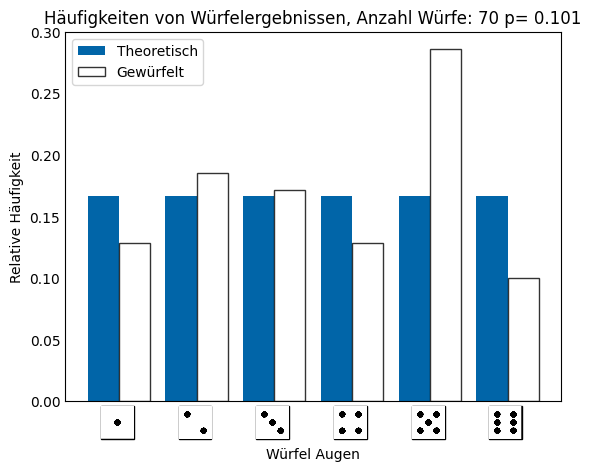

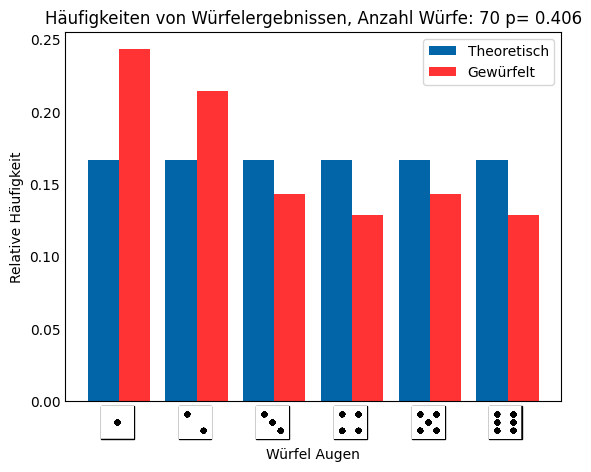

In [20]:

# if dice prediction is available, show it    
dice_prediction = True # assume state sets to capture

for _ in range(10):
    if dice_prediction:
        dice_dict, dice_pass = dummy_dice_pred()
        if not dice_pass:
            print("INVALID THROW, Please try again!")
            # TODO add to ouptu message
        else:
            if check_empty_dice_results(f'results.csv'):
                throw_number=0
                print("First throw")
            throw_number += 1
            
            dice_dict_NA=create_dataframe_fillNA(dice_dict)
            dice_dict_NA['throw'] = [throw_number] * len(dice_dict['white'])
            
            append_to_csv('results.csv', dice_dict_NA)
            warnings.simplefilter(action='ignore', category=FutureWarning)
            dice_msg="Dice: "+str(dice_dict)
            print(dice_msg)
        
df = pd.read_csv('results.csv')
histplot(df['white'].dropna().tolist(),dicecolor='white')
histplot(df['red'].dropna().tolist(),dicecolor='red')

In [96]:
df = pd.read_csv('results.csv')
histplot(df['white'].dropna().tolist(),dicecolor='white')
histplot(df['red'].dropna().tolist(),dicecolor='red')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   throw   50 non-null     int64  
 1   white   28 non-null     float64
 2   red     45 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 1.3 KB
